# BigTransfer (BiT) State-of-the-art transfer learning for image classification.

**Author:** [Ashaduzzaman Sarker](https://github.com/ashaduzzaman-sarker/)
<br>
**Date created:** 02/07/2024
<Br>
**Reference:**
- [Big Transfer (BiT): General Visual Representation Learning](
https://doi.org/10.48550/arXiv.1912.11370)

- [Keras](https://keras.io/examples/vision/bit/)



## **Introduction**

BigTransfer (BiT) is a leading-edge transfer learning technique for image classification that enhances the efficiency of sample usage and simplifies hyperparameter tuning in deep neural network training for vision tasks. By pre-training on extensive supervised datasets and then fine-tuning on specific tasks, BiT leverages the power of pre-trained representations. It emphasizes the critical role of selecting appropriate normalization layers and scaling the model's architecture capacity in proportion to the pre-training data size.

BiT models are trained on public datasets and provided with code in TensorFlow 2, Jax, and PyTorch, enabling users to achieve state-of-the-art performance on various tasks, even with minimal labeled images per class. Pre-trained BiT models are available on TFHub as TensorFlow 2 SavedModels, easily integrable as Keras Layers. These models range from a standard ResNet50 to a more complex ResNet152x4, accommodating users with different computational and accuracy needs.

![](https://i.imgur.com/XeWVfe7.jpeg)

## Imports

In [1]:
!pip install --upgrade keras

In [2]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import ops
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

SEEDS = 42

keras.utils.set_random_seed(SEEDS)

## Load Flower Dataset

In [3]:
train_ds, validation_ds = tfds.load(
    'tf_flowers',
    split=['train[:85%]', 'train[85%:]'],
    as_supervised = True,
)

## Visualize the dataset

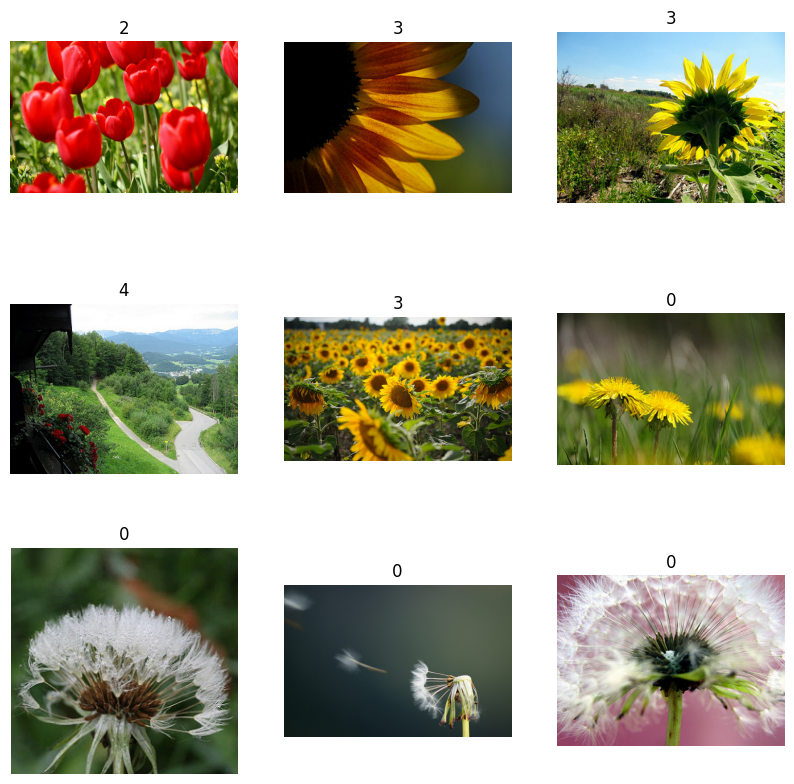

In [4]:
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis('off')

## Define hyperparameters


In [5]:
RESIZE_TO = 384
CROP_TO = 224
BATCH_SIZE = 64
STEPS_PER_EPOCH = 10
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5
SCHEDULE_LENGTH = (500)
SCHEDULE_BOUNDARIES = [200, 300, 400]

## Define preprocessing helper functions

In [6]:
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

random_flip = keras.layers.RandomFlip('horizontal')
random_crop = keras.layers.RandomCrop(CROP_TO, CROP_TO)

def preprocess_train(image, label):
  image = random_flip(image)
  image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
  image = random_crop(image)
  image = image / 255.0
  return (image, label)

def preprocess_test(image, label):
  image = ops.image.resize(image, (RESIZE_TO, RESIZE_TO))
  image = ops.cast(image, dtype='float32')
  image = image / 255.0
  return (image, label)

DATASET_NUM_TRAIN_EXAMPLES = train_ds.cardinality().numpy()

repeat_count = int(
    SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH
)

repeat_count += 50 + 1

## Define the data pipeline

In [7]:
# Training Pipeline
pipeline_train = (
    train_ds.shuffle(10000)
    .repeat(repeat_count)
    .map(preprocess_train, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Validation Pipeline
pipeline_validation = (
    validation_ds.map(preprocess_test, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Visualise the training samples

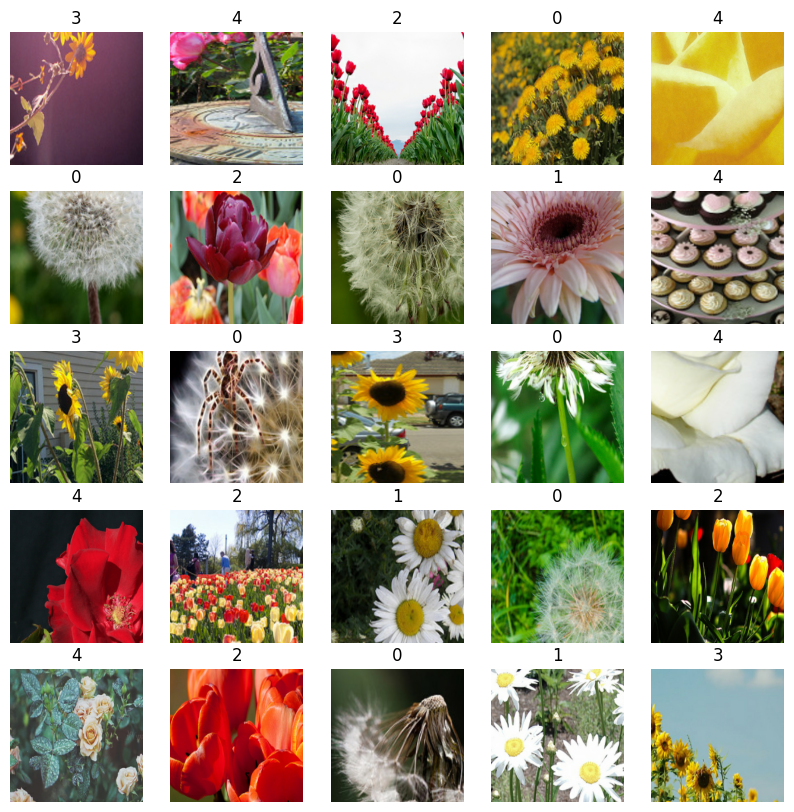

In [8]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
  ax = plt.subplot(5, 5, n + 1)
  plt.imshow(image_batch[n])
  plt.title(label_batch[n].numpy())
  plt.axis('off')

## Load pretrained TF-Hub model into a KerasLayer

In [9]:
bit_model_url = 'https://tfhub.dev/google/bit/m-r50x1/1'
bit_module = hub.load(bit_model_url)

## Create BigTransfer (BiT) model

To create a new BiT model, follow these steps:

1. **Remove the Original Head**: Detach the original head of the BiT model, leaving the “pre-logits” output. This step is unnecessary if using the 'feature extractor' models (located in subdirectories titled `feature_vectors`), as these models already have the head removed.

2. **Add a New Head**: Attach a new head to the model, with the number of outputs corresponding to the number of classes in your new task. It is crucial to initialize this new head with all zeroes to ensure proper training.

In [10]:
class MyBiTModel(keras.Model):
  def __init__(self, num_classes, module, **kwargs):
    super().__init__(**kwargs)

    self.num_classes = num_classes
    self.head = keras.layers.Dense(num_classes, kernel_initializer = 'zeros')
    self.bit_model = module

  def call(self, images):
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=bit_module)


## Define optimizer and loss

In [11]:
learning_rate = 0.003 * BATCH_SIZE / 512

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES
lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=SCHEDULE_BOUNDARIES,
    values=[
        learning_rate,
        learning_rate * 0.1,
        learning_rate * 0.01,
        learning_rate * 0.001,
    ],
)

optimizer = keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Compile the model

In [12]:
model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy'],
)

## Set up Callbacks

In [13]:
train_callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=2,
        restore_best_weights=True,
    )
]

## Train the model

In [14]:
history = model.fit(
    pipeline_train,
    batch_size= BATCH_SIZE,
    epochs=int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=pipeline_validation,
    callbacks=train_callbacks,
)

Epoch 1/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 394s 37s/step - accuracy: 0.6166 - loss: 1.1114 - val_accuracy: 0.9618 - val_loss: 0.1869
Epoch 2/400
10/10 ━━━━━━━━━━━━━━━━━━━━ 283s 28s/step - accuracy: 0.9411 - loss: 0.1837 - val_accuracy: 0.9691 - val_loss: 0.1127
Epoch 3/400
 2/10 ━━━━━━━━━━━━━━━━━━━━ 3:42 28s/step - accuracy: 0.9336 - loss: 0.2023

InternalError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-14-867a45905272>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Failed to allocate 38535168 bytes for new constant
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_78858]

## Plot the training and validation metrics

In [ ]:
def plot_hist(hist):
  plt.plot(hist.history['accuracy'])
  plt.plot(hist.history['val_accuracy'])
  plt.plot(hist.history['loss'])
  plt.plot(hist.history['val_loss'])
  plt.title('Training Progress')
  plt.ylabel('Accuracy/loss')
  plt.xlabel('Epochs')
  plt.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc='upper_left')
  plt.show()

plot_hist(history)

## Evaluate the model

In [ ]:
accuracy = model.evaluate(pipeline_validation)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))